<!-- dom:TITLE: Programmation Python  pour les mathématiques -->
# Numerical methods for time-dependent PDE
## TP3 - Error measurements
<!-- dom:AUTHOR: Julien Guillod at [Sorbonne Université](http://www.sorbonne-universite.fr/), -->
<!-- Author: -->
**Julien Guillod**, [Sorbonne Université](http://www.sorbonne-universite.fr/),
Licence <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">CC BY-NC-ND</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Basic definitions

In [2]:
# definition of the functions for the initial data
def u01(x):
    return np.sin(2*np.pi*x)

@np.vectorize
def u02(x):
    x = x % 1
    if 0 <= x <= 1/4 or 3/4 <= x <= 1:
        return 0.
    else:
        return 1.

In [3]:
# Class to initalize and run the problem
class simulate:
    
    def __init__(self):
        self.Lx = 1
        self.Nx = 100
        self.cfl = 0.3
        self.T = 0.3

    def update(self):
        self.x = np.linspace(0, self.Lx, self.Nx, endpoint=False) # space grid
        self.dx = self.x[1]-self.x[0] # spatial step
        self.dt = self.cfl*self.dx # time step
        self.t = np.arange(0,self.T,self.dt) # time grid

    def run(self):
        self.update()
        method = self.method
        errors = []
        # time stepping
        for time in self.t:
            if time == 0:
                u = self.u0(self.x)
            else:
                u = method(u, self.cfl)
            # compute error if required
            if hasattr(self,'norm'):
                errors.append(np.linalg.norm(u - self.u0(self.x-time), self.norm))
        self.u = u
        # rescale norm by dx
        if hasattr(self,'norm') and self.norm == np.inf:
            self.errors = np.array(errors)
        elif hasattr(self,'norm'):
            self.errors = np.array(errors)*self.dx**(1/self.norm)
        return u

### Scheme definitions

In [4]:
# Lax-Wendroff scheme
def lax_wendroff(u, CFL):
    du = np.zeros_like(u)
    du[1:-1] = (u[2:]-u[:-2])/2 + CFL*(2*u[1:-1]-u[2:]-u[:-2])/2
    du[0] = (u[1]-u[-1])/2 + CFL*(2*u[0]-u[1]-u[-1])/2
    du[-1] = (u[0]-u[-2])/2 + CFL*(2*u[-1]-u[0]-u[-2])/2
    u -= CFL*du
    return u

In [5]:
# upwind scheme
def upwind(u, CFL):
    du = np.zeros_like(u)
    du[1:] = (u[1:]-u[:-1])
    du[0] = (u[0]-u[-1])
    u -= CFL*du
    return u

### Convergence

In [6]:
# get errors at t=T for various Nx
@np.vectorize
def error_Nx(s,Nx):
    s.Nx = Nx
    s.run()
    return s.errors[-1]

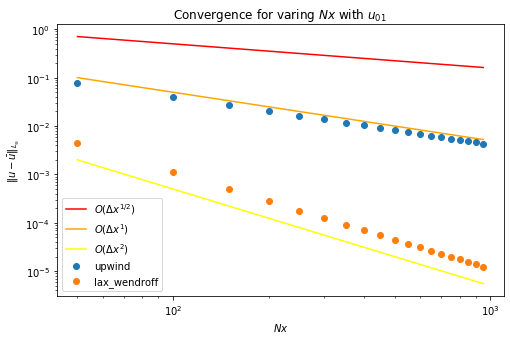

In [7]:
# Compare convergence for various spatial discretizations for u01
s = simulate()
s.u0 = u01
s.norm = np.inf
# list of discretizations
NN = np.array(range(50,1000,50))
# list of methods
methods = [upwind, lax_wendroff]
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for varing $Nx$ with $u_{01}$")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_\infty}$')
plt.loglog(NN,5*NN**-0.5, "r", label=r'$O(\Delta x^{1/2})$')
plt.loglog(NN,5/NN, "orange", label=r'$O(\Delta x^{1})$')
plt.loglog(NN,5/NN**2, "yellow", label=r'$O(\Delta x^{2})$')
for m in methods:
    s.method = m
    plt.loglog(NN, error_Nx(s,NN), "o", label=m.__name__)
plt.legend()
plt.show()

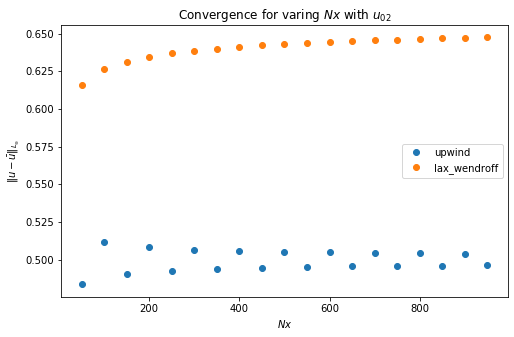

In [8]:
# Compare convergence for various spatial discretizations for u02
s = simulate()
s.u0 = u02
s.norm = np.inf
# list of discretizations
NN = np.array(range(50,1000,50))
# list of methods
methods = [upwind, lax_wendroff]
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for varing $Nx$ with $u_{02}$")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_\infty}$')
for m in methods:
    s.method = m
    plt.plot(NN, error_Nx(s,NN), "o", label=m.__name__)
plt.legend()
plt.show()

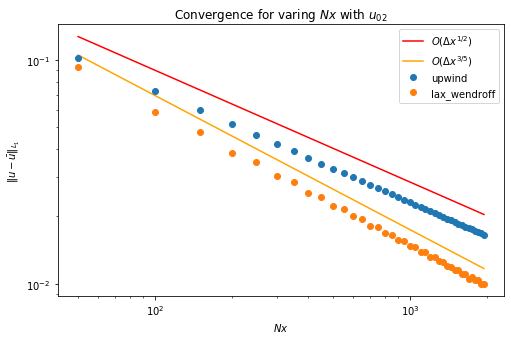

In [9]:
# Compare convergence for various spatial discretizations for u02
s = simulate()
s.u0 = u02
s.norm = 1
# list of discretizations
NN = np.array(range(50,2000,50))
# list of methods
methods = [upwind, lax_wendroff]
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for varing $Nx$ with $u_{02}$")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_1}$')
plt.loglog(NN, 0.9*NN**-(1/2), "r", label=r'$O(\Delta x^{1/2})$')
plt.loglog(NN, 1.1*NN**-(3/5), "orange", label=r'$O(\Delta x^{3/5})$')
for m in methods:
    s.method = m
    plt.loglog(NN, error_Nx(s,NN), "o", label=m.__name__)
plt.legend()
plt.show()

In [10]:
# fit for Lax-Wendroff
s.method = lax_wendroff
NN = np.array(range(50,2000,50))
np.polyfit(np.log(NN),np.log(error_Nx(s,NN)),1)

array([-0.60594696, -0.02448822])